In [1]:
# all imports

import time
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/nicolas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/nicolas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nicolas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/nicolas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicolas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# knn_with_vs_without_stopwords.py

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}.get(tag, wordnet.NOUN)

stop_words = set(stopwords.words('english'))
additional_stopwords = {"al", "god", "https", "ahly", "http"}
stop_words = stop_words.union(additional_stopwords)

def preprocess_with_stopwords(tweet):
    tweet = tweet.lower()
    words = re.findall(r'\b[a-zA-Z]+\b', tweet)
    lemmatizer = WordNetLemmatizer()
    processed_words = []
    for w in words:
        lemma = lemmatizer.lemmatize(w, get_wordnet_pos(w))
        if lemma not in stop_words:
            processed_words.append(lemma)
    return " ".join(processed_words)

def preprocess_without_stopwords(tweet):
    tweet = tweet.lower()
    words = re.findall(r'\b[a-zA-Z]+\b', tweet)
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words])

df = pd.read_csv("./assets/combined.csv")
df.dropna(subset=["tweet", "Status"], inplace=True)

df["processed_with"] = df["tweet"].apply(preprocess_with_stopwords)
df["processed_without"] = df["tweet"].apply(preprocess_without_stopwords)

vectorizer = TfidfVectorizer()
X_with = vectorizer.fit_transform(df["processed_with"])
X_without = vectorizer.fit_transform(df["processed_without"])
y = df["Status"]

X_train, X_test, y_train, y_test = train_test_split(X_with, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("KNN (mit Stopwords) Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_without, y, test_size=0.2, random_state=42)
knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(X_train2, y_train2)
y_pred2 = knn2.predict(X_test2)

print("KNN (ohne Stopwords) Accuracy:", accuracy_score(y_test2, y_pred2))
print(classification_report(y_test2, y_pred2))

KNN (mit Stopwords) Accuracy: 0.6505793811969897
              precision    recall  f1-score   support

           0       0.93      0.36      0.52      4420
           1       0.58      0.97      0.72      3951

    accuracy                           0.65      8371
   macro avg       0.76      0.67      0.62      8371
weighted avg       0.77      0.65      0.62      8371

KNN (ohne Stopwords) Accuracy: 0.6873730737068451
              precision    recall  f1-score   support

           0       0.85      0.49      0.62      4420
           1       0.61      0.90      0.73      3951

    accuracy                           0.69      8371
   macro avg       0.73      0.70      0.68      8371
weighted avg       0.74      0.69      0.68      8371



In [3]:
# knn unigram vs ngram

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}.get(tag, wordnet.NOUN)

stop_words = set(stopwords.words('english'))
additional_stopwords = {"al", "god", "https", "ahly", "http"}
stop_words = stop_words.union(additional_stopwords)

def preprocess(tweet):
    tweet = tweet.lower()
    words = re.findall(r'\b[a-zA-Z]+\b', tweet)
    lemmatizer = WordNetLemmatizer()
    processed_words = []
    for w in words:
        lemma = lemmatizer.lemmatize(w, get_wordnet_pos(w))
        if lemma not in stop_words:
            processed_words.append(lemma)
    return " ".join(processed_words)

df = pd.read_csv("./assets/combined.csv")
df.dropna(subset=["tweet", "Status"], inplace=True)
df["processed_tweet"] = df["tweet"].apply(preprocess)
y = df["Status"]

vectorizer_uni = TfidfVectorizer(ngram_range=(1,1))
X_uni = vectorizer_uni.fit_transform(df["processed_tweet"])

vectorizer_bi = TfidfVectorizer(ngram_range=(1,2))
X_bi = vectorizer_bi.fit_transform(df["processed_tweet"])

X_train_uni, X_test_uni, y_train_uni, y_test_uni = train_test_split(X_uni, y, test_size=0.2, random_state=42)
knn_uni = KNeighborsClassifier(n_neighbors=5)
knn_uni.fit(X_train_uni, y_train_uni)
y_pred_uni = knn_uni.predict(X_test_uni)
print("KNN Unigram Accuracy:", accuracy_score(y_test_uni, y_pred_uni))
print(classification_report(y_test_uni, y_pred_uni))

X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(X_bi, y, test_size=0.2, random_state=42)
knn_bi = KNeighborsClassifier(n_neighbors=5)
knn_bi.fit(X_train_bi, y_train_bi)
y_pred_bi = knn_bi.predict(X_test_bi)
print("KNN Unigram+Bigram Accuracy:", accuracy_score(y_test_bi, y_pred_bi))
print(classification_report(y_test_bi, y_pred_bi))

KNN Unigram Accuracy: 0.6505793811969897
              precision    recall  f1-score   support

           0       0.93      0.36      0.52      4420
           1       0.58      0.97      0.72      3951

    accuracy                           0.65      8371
   macro avg       0.76      0.67      0.62      8371
weighted avg       0.77      0.65      0.62      8371

KNN Unigram+Bigram Accuracy: 0.5268187791183849
              precision    recall  f1-score   support

           0       0.84      0.13      0.22      4420
           1       0.50      0.97      0.66      3951

    accuracy                           0.53      8371
   macro avg       0.67      0.55      0.44      8371
weighted avg       0.68      0.53      0.43      8371



In [4]:
# knn l2 normalized 

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}.get(tag, wordnet.NOUN)

stop_words = set(stopwords.words('english'))
additional_stopwords = {"al", "god", "https", "ahly", "http"}
stop_words = stop_words.union(additional_stopwords)

def preprocess(tweet):
    tweet = tweet.lower()
    words = re.findall(r'\b[a-zA-Z]+\b', tweet)
    lemmatizer = WordNetLemmatizer()
    processed_words = []
    for w in words:
        lemma = lemmatizer.lemmatize(w, get_wordnet_pos(w))
        if lemma not in stop_words:
            processed_words.append(lemma)
    return " ".join(processed_words)

df = pd.read_csv("./assets/combined.csv")
df.dropna(subset=["tweet", "Status"], inplace=True)
df["processed_tweet"] = df["tweet"].apply(preprocess)
y = df["Status"]

tfidf = TfidfVectorizer(norm=None)
X_tfidf = tfidf.fit_transform(df["processed_tweet"])

from sklearn.preprocessing import Normalizer
normalizer = Normalizer(norm="l2")
X_norm = normalizer.transform(X_tfidf)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("KNN (L2 normalisiert) Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

KNN (L2 normalisiert) Accuracy: 0.6505793811969897
              precision    recall  f1-score   support

           0       0.93      0.36      0.52      4420
           1       0.58      0.97      0.72      3951

    accuracy                           0.65      8371
   macro avg       0.76      0.67      0.62      8371
weighted avg       0.77      0.65      0.62      8371



In [5]:
# K tuning and TFIDF

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}.get(tag, wordnet.NOUN)

stop_words = set(stopwords.words('english'))
additional_stopwords = {"al", "god", "https", "ahly", "http"}
stop_words = stop_words.union(additional_stopwords)

def preprocess(tweet):
    tweet = tweet.lower()
    words = re.findall(r'\b[a-zA-Z]+\b', tweet)
    lemmatizer = WordNetLemmatizer()
    processed_words = []
    for w in words:
        lemma = lemmatizer.lemmatize(w, get_wordnet_pos(w))
        if lemma not in stop_words:
            processed_words.append(lemma)
    return " ".join(processed_words)

df = pd.read_csv("./assets/combined.csv")
df.dropna(subset=["tweet", "Status"], inplace=True)
df["processed_tweet"] = df["tweet"].apply(preprocess)

X = df["processed_tweet"]
y = df["Status"]

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

k_values = [1, 2, 3, 5, 6, 8, 10]
results = {}

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    start_time = time.time()
    y_pred = knn.predict(X_test)
    elapsed = time.time() - start_time
    acc = accuracy_score(y_test, y_pred)
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    results[k] = (acc, weighted_f1, macro_f1, elapsed)
    print(f"k = {k} | Accuracy: {acc:.4f} | Weighted F1: {weighted_f1:.4f} | Macro F1: {macro_f1:.4f} | Prediction Time: {elapsed:.4f} sec")

k = 1 | Accuracy: 0.7335 | Weighted F1: 0.7204 | Macro F1: 0.7234 | Prediction Time: 1.7810 sec
k = 2 | Accuracy: 0.7317 | Weighted F1: 0.7193 | Macro F1: 0.7222 | Prediction Time: 1.8834 sec
k = 3 | Accuracy: 0.6615 | Weighted F1: 0.6285 | Macro F1: 0.6341 | Prediction Time: 1.9733 sec
k = 5 | Accuracy: 0.6506 | Weighted F1: 0.6183 | Macro F1: 0.6239 | Prediction Time: 3.4613 sec
k = 6 | Accuracy: 0.6552 | Weighted F1: 0.6292 | Macro F1: 0.6342 | Prediction Time: 3.3687 sec
k = 8 | Accuracy: 0.6310 | Weighted F1: 0.5889 | Macro F1: 0.5956 | Prediction Time: 3.4129 sec
k = 10 | Accuracy: 0.6085 | Weighted F1: 0.5534 | Macro F1: 0.5615 | Prediction Time: 3.5631 sec


In [6]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}.get(tag, wordnet.NOUN)

stop_words = set(stopwords.words('english'))
additional_stopwords = {"al", "god", "https", "ahly", "http"}
stop_words = stop_words.union(additional_stopwords)

def preprocess(tweet):
    tweet = tweet.lower()
    words = re.findall(r'\b[a-zA-Z]+\b', tweet)
    lemmatizer = WordNetLemmatizer()
    processed_words = []
    for w in words:
        lemma = lemmatizer.lemmatize(w, get_wordnet_pos(w))
        if lemma not in stop_words:
            processed_words.append(lemma)
    return " ".join(processed_words)

df = pd.read_csv("./assets/combined.csv")
df.dropna(subset=["tweet", "Status"], inplace=True)
df["processed_tweet"] = df["tweet"].apply(preprocess)

X = df["processed_tweet"]
y = df["Status"]

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Weighted F1:", f1_score(y_test, y_pred, average='weighted'))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

Accuracy: 0.7334846493847808
Weighted F1: 0.720446774522609
Macro F1: 0.7234050538212827
              precision    recall  f1-score   support

           0       0.97      0.51      0.67      4420
           1       0.64      0.98      0.78      3951

    accuracy                           0.73      8371
   macro avg       0.80      0.75      0.72      8371
weighted avg       0.81      0.73      0.72      8371



In [7]:
# Cross Validation

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}.get(tag, wordnet.NOUN)

stop_words = set(stopwords.words('english'))
additional_stopwords = {"al", "god", "https", "ahly", "http"}
stop_words = stop_words.union(additional_stopwords)

def preprocess(tweet):
    tweet = tweet.lower()
    words = re.findall(r'\b[a-zA-Z]+\b', tweet)
    lemmatizer = WordNetLemmatizer()
    processed_words = []
    for w in words:
        lemma = lemmatizer.lemmatize(w, get_wordnet_pos(w))
        if lemma not in stop_words:
            processed_words.append(lemma)
    return " ".join(processed_words)

df = pd.read_csv("./assets/combined.csv")
df.dropna(subset=["tweet", "Status"], inplace=True)
df["processed_tweet"] = df["tweet"].apply(preprocess)

X = df["processed_tweet"]
y = df["Status"]

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13]}

knn = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid.fit(X_tfidf, y)

print("Beste Parameter:", grid.best_params_)
print("Bestes durchschnittliches Accuracy (CV):", grid.best_score_)

y_pred_cv = grid.predict(X_tfidf)
print("Klassifikationsbericht (CV auf dem gesamten Datensatz):")
print(classification_report(y, y_pred_cv))

Beste Parameter: {'n_neighbors': 5}
Bestes durchschnittliches Accuracy (CV): 0.6510238952907768
Klassifikationsbericht (CV auf dem gesamten Datensatz):
              precision    recall  f1-score   support

           0       0.97      0.53      0.69     21863
           1       0.66      0.98      0.79     19988

    accuracy                           0.75     41851
   macro avg       0.81      0.76      0.74     41851
weighted avg       0.82      0.75      0.73     41851



In [8]:
# Hyperparameter Tuning

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}.get(tag, wordnet.NOUN)

stop_words = set(stopwords.words('english'))
additional_stopwords = {"al", "god", "https", "ahly", "http"}
stop_words = stop_words.union(additional_stopwords)

def preprocess(tweet):
    tweet = tweet.lower()
    words = re.findall(r'\b[a-zA-Z]+\b', tweet)
    lemmatizer = WordNetLemmatizer()
    processed_words = []
    for w in words:
        lemma = lemmatizer.lemmatize(w, get_wordnet_pos(w))
        if lemma not in stop_words:
            processed_words.append(lemma)
    return " ".join(processed_words)

df = pd.read_csv("./assets/combined.csv")
df.dropna(subset=["tweet", "Status"], inplace=True)
df["processed_tweet"] = df["tweet"].apply(preprocess)

X = df["processed_tweet"]
y = df["Status"]

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'cosine']
}

knn = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)
print("Bestes CV-Accuracy:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Beste Parameter: {'metric': 'cosine', 'n_neighbors': 19, 'weights': 'distance'}
Bestes CV-Accuracy: 0.9246714456391876
Test Accuracy: 0.9273682953052204
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4420
           1       0.92      0.92      0.92      3951

    accuracy                           0.93      8371
   macro avg       0.93      0.93      0.93      8371
weighted avg       0.93      0.93      0.93      8371



In [9]:
# Hyperparameter Tuning

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}.get(tag, wordnet.NOUN)

stop_words = set(stopwords.words('english'))
additional_stopwords = {"al", "god", "https", "ahly", "http"}
stop_words = stop_words.union(additional_stopwords)

def preprocess(tweet):
    tweet = tweet.lower()
    words = re.findall(r'\b[a-zA-Z]+\b', tweet)
    lemmatizer = WordNetLemmatizer()
    processed_words = []
    for w in words:
        lemma = lemmatizer.lemmatize(w, get_wordnet_pos(w))
        if lemma not in stop_words:
            processed_words.append(lemma)
    return " ".join(processed_words)

df = pd.read_csv("./assets/combined.csv")
df.dropna(subset=["tweet", "Status"], inplace=True)
df["processed_tweet"] = df["tweet"].apply(preprocess)

X = df["processed_tweet"]
y = df["Status"]

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

param_grid = {
    'n_neighbors': [1, 5, 10, 15, 20, 25, 30, 32, 34, 36, 38, 39, 40, 41, 42, 44, 46, 48, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'cosine']
}

knn = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)
print("Bestes CV-Accuracy:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Beste Parameter: {'metric': 'cosine', 'n_neighbors': 40, 'weights': 'distance'}
Bestes CV-Accuracy: 0.9268817204301076
Test Accuracy: 0.9280850555489188
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4420
           1       0.93      0.92      0.92      3951

    accuracy                           0.93      8371
   macro avg       0.93      0.93      0.93      8371
weighted avg       0.93      0.93      0.93      8371



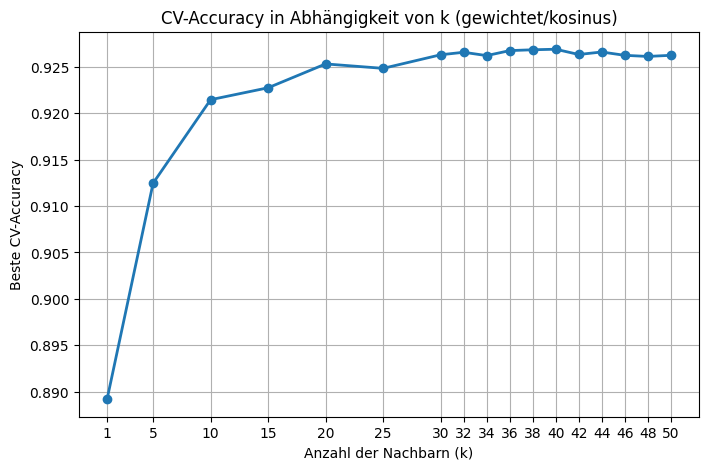

In [10]:
import numpy as np
import matplotlib.pyplot as plt


results = grid_search.cv_results_
n_values     = np.array(results['param_n_neighbors'].data, dtype=int)
mean_scores  = np.array(results['mean_test_score'], dtype=float)

unique_ns = np.unique(n_values)
best_scores = []
for n in unique_ns:
    mask = n_values == n
    best_scores.append(mean_scores[mask].max())

plt.figure(figsize=(8,5))
plt.plot(unique_ns, best_scores, marker='o', linewidth=2)
plt.xticks(unique_ns)
plt.xlabel("Anzahl der Nachbarn (k)")
plt.ylabel("Beste CV-Accuracy")
plt.title("CV-Accuracy in Abhängigkeit von k (gewichtet/kosinus)")
plt.grid(True)
plt.show()